# Activity 2.4: symmetric Krylov races

In [1]:
%pip install numpy scipy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, dia_matrix
from scipy.linalg import qr, solve_triangular

Note: you may need to restart the kernel to use updated packages.


## Comparing CG with a mathematically equivalent method

The SYMMLQ Krylov subspace method generates approximate solutions that are "quasioptimal": the system that is solved does not correspond to either the orthogonal or the oblique projection problem, but it can also be used to generate the CG iterates in a way that is potentially more stable when the computation of the coefficients $\alpha_k$ or $\beta_k$ is numerically ill-conditioned due to having a small denominator.  The reason the SYMMLQ
method is more numerically stable is because it is based on an LQ factorization of the Lanczos matrix $T_m$.

In [2]:
def conjugate_gradient(A, r, maxiter, rtol=1.e-12, atol=0.):
    r = r.copy()
    rho = rho0 = r.dot(r)
    x = np.zeros(r.shape)
    xs = [x.copy()]
    rnorms = [rho**0.5]
    if rho < atol*atol:
        return xs, rnorms
    p = r.copy()
    q = p.copy()
    for i in range(maxiter):
        q[:] = A @ p
        alpha = rho / p.dot(q)
        x[:] = x + alpha * p
        xs.append(x.copy())
        r[:] = r - alpha * q
        rhonew = r.dot(r)
        rnorms.append(rhonew**0.5)
        if rhonew < rtol * rtol * rho0 or rhonew < atol * atol:
            return xs, rnorms
        beta = rhonew / rho
        rho = rhonew
        p[:] = r + beta * p
    return xs, rnorms         

In [3]:
def dlanczos_symmlq(A, r, maxiter, rtol=1.e-12, atol=0.):
    r = r.copy()
    res = res0 = np.linalg.norm(r)
    x = np.zeros(r.shape)
    xs = [x.copy()]
    rnorms = [res]
    if res < atol:
        return xs, rnorms
    vim1 = np.zeros(r.shape)
    vi = r / res
    wbari = -vi.copy()
    wi = vi.copy()
    cosim2 = 1.
    sinim2 = 0.
    cosim1 = 1.
    sinim1 = 0.
    vip1 = np.ndarray(r.shape)
    betai = 0.
    zim2 = 0.
    zim1 = 0.
    rhs = res
    for i in range(maxiter):
        # Lanczos iteration
        vip1[:] = A @ vi
        vip1[:] = vip1 - betai * vim1
        alphai = vip1.dot(vi)
        vip1[:] = vip1 - alphai * vi
        betaip1 = np.linalg.norm(vip1)
        vip1[:] = vip1 / betaip1
        # Apply previous reflection
        epsiloni  =  sinim2 * betai
        deltabari = -cosim2 * betai
        deltai    = cosim1 * deltabari + sinim1 * alphai
        gammabari = sinim1 * deltabari - cosim1 * alphai
        # Compute the new reflection
        gb = (gammabari * gammabari + betaip1 * betaip1)**0.5
        cosi = gammabari / gb
        sini = betaip1 / gb
        # Apply the new reflection
        gammai = cosi * gammabari + sini * betaip1
        # Compute the new component of z
        zi = (rhs - epsiloni * zim2 - deltai * zim1) / gammai
        rhs = 0.
        zbari = zi / cosi
        res = res * sini 
        # Output the conjugate gradient solution and residual
        xs.append(x + zbari * wbari)
        rnorms.append(np.abs(res / cosi))
        if res < rtol * res0 or res < atol:
            return xs, rnorms
        # rotate the vectors
        wi[:] = cosi * wbari + sini * vip1
        x[:] = x + zi * wi
        wbari[:] = sini * wbari - cosi * vip1
        # increment
        vim1[:] = vi
        vi[:] = vip1
        betai = betaip1
        zim2 = zim1
        zim1 = zi
        cosim2 = cosim1
        sinim2 = sinim1
        cosim1 = cosi
        sinim1 = sini
    return xs, rnorms        

To compare the two methods that are mathemtically equivalent we will use the same matrix that Paige & Saunders used in deriving the SYMMLQ method, $B = L^2 - \mu I$, where $L$ is the FD Laplacian.

This can be used to test well-conditioned matrices ($\mu > 0$), ill-conditioned matrices ($\mu = 0$), or even indefinite matrices $(\mu < 0)$ when CG is not guaranteed to converge.

In [4]:
def paige_saunders_matrix(n, mu):
    A = dia_matrix((np.array([[-1,2,-1]]).T @ np.ones((1,n)),[-1,0,1]),shape=(n,n))
    return (A @ A).toarray() + mu * np.eye(n)

We generate 30 random right hand sides and scatter plot:

1. The energy error norm (should be monotonically decreasing)
2. The error in the calculated residual norm (indicates the accumulation of rounding errors are affecting the calculations)
3. The actual residual norm (relative to $\|r_0\|$)
4. The difference between the $x_m$s computed by the two methods

condition of A: 279.44485444758953
-1.732036418121359 14.237616841671324


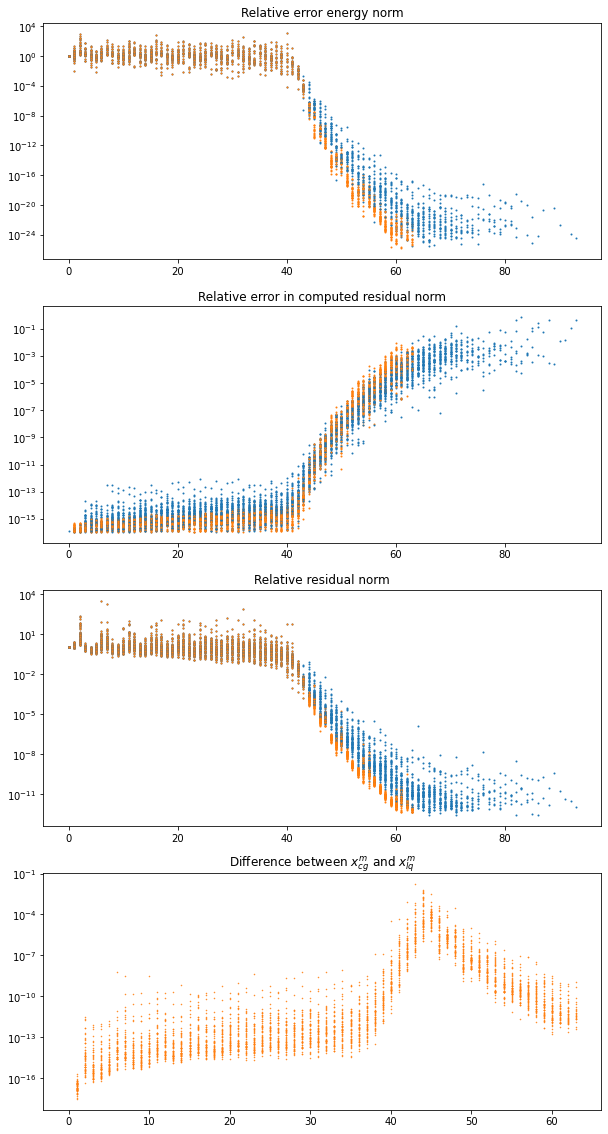

In [11]:
n = 50
m = 500
A = paige_saunders_matrix(n, -3.**0.5)
Q, R, P = qr(A, pivoting=True)
print("condition of A:", np.linalg.cond(A))
print(np.linalg.eigvals(A).min(), np.linalg.eigvals(A).max())
ntrials = 30
fig, axs = plt.subplots(4, 1, figsize=(10, 20))
axs[0].set(title="Relative error energy norm")
axs[1].set(title="Relative error in computed residual norm")
axs[2].set(title="Relative residual norm")
axs[3].set(title="Difference between $x^m_{cg}$ and $x^m_{lq}$")
for trial in range(ntrials*2):
    # Generate a random rhs
    r = np.random.randn(n)
    # Compute the true solution as accurately as possible
    xstar = np.ndarray(r.shape)
    xstar[P] = solve_triangular(R, Q.T @ r)
    xs_cg, rnorms_cg = conjugate_gradient(A, r, m)
    xs_lq, rnorms_lq = dlanczos_symmlq(A, r, m)
    Aerrs_cg = np.array([(xstar - x).dot(A @ (xstar - x)) for x in xs_cg])
    Aerrs_lq = np.array([(xstar - x).dot(A @ (xstar - x)) for x in xs_lq])
    true_rnorms_cg = np.array([np.linalg.norm(A @ x - r) for x in xs_cg])
    true_rnorms_lq = np.array([np.linalg.norm(A @ x - r) for x in xs_lq])
    axs[0].semilogy(range(len(Aerrs_cg)), Aerrs_cg/Aerrs_cg[0], 'C0.',markersize=2)
    axs[0].semilogy(range(len(Aerrs_lq)), Aerrs_lq/Aerrs_lq[0], 'C1.',markersize=2)
    axs[1].semilogy(range(len(true_rnorms_cg)), np.abs(rnorms_cg - true_rnorms_cg) / true_rnorms_cg,'C0.',markersize=2)
    axs[1].semilogy(range(len(true_rnorms_lq)), np.abs(rnorms_lq - true_rnorms_lq) / true_rnorms_lq,'C1.',markersize=2)
    axs[2].semilogy(range(len(true_rnorms_cg)), true_rnorms_cg / np.linalg.norm(r),'C0.',markersize=2)
    axs[2].semilogy(range(len(true_rnorms_lq)), true_rnorms_lq / np.linalg.norm(r),'C1.',markersize=2)
    k = min(len(xs_cg), len(xs_lq))
    diff_lq = [np.linalg.norm(x - xl) / np.linalg.norm(xstar) for x,xl in zip(xs_cg[:k], xs_lq[:k])]
    axs[3].semilogy(range(k), diff_lq, 'C1.',markersize=1)

In [6]:
def conjugate_residual(A, r, maxiter, rtol=1.e-12, atol=0.):
    r = r.copy()
    ressq0 = ressq = r.dot(r)
    x = np.zeros(r.shape)
    xs = [x.copy()]
    rnorms = [ressq0**0.5]
    if ressq0 < atol*atol:
        return xs, rnorms
    p = r.copy()
    q = A @ r
    s = q.copy()
    rho = q.dot(r)
    for i in range(maxiter):
        alpha = rho / s.dot(s)
        x[:] = x + alpha * p
        xs.append(x.copy())
        r[:] = r - alpha * s
        q[:] = A @ r
        rhonew = q.dot(r)
        ressq = r.dot(r)
        rnorms.append(ressq**0.5)
        if ressq < rtol * rtol * ressq0 or ressq < atol * atol:
            return xs, rnorms
        beta = rhonew / rho
        rho = rhonew
        p[:] = r + beta * p
        s[:] = q + beta * s
    return xs, rnorms   

In [7]:
def minres(A, r, maxiter, rtol=1.e-12, atol=0.):
    x = np.zeros(r.shape)
    xs = [x.copy()]
    sbari = res0 = np.linalg.norm(r)
    rnorms = [sbari]
    if sbari < atol:
        return xs, rnorms
    vim1 = np.zeros(r.shape)
    vi = r / sbari
    vip1 = np.ndarray(r.shape)
    uim2 = np.zeros(r.shape)
    uim1 = np.zeros(r.shape)
    betai = 0.
    cosim2 = 1.
    sinim2 = 0.
    cosim1 = 1.
    sinim1 = 0.
    for i in range(maxiter):
        # Compute the next vector by Lanczos recurrence
        vip1[:] = A @ vi
        vip1[:] = vip1 - betai * vim1
        alphai = vip1.dot(vi)
        vip1[:] = vip1 - alphai * vi
        betaip1 = np.linalg.norm(vip1)
        vip1[:] = vip1 / betaip1
        # apply the last two Givens rotations to
        # (0, betai, alphai)
        # to get (epsiloni, deltai, gammabari)
        epsiloni  = - sinim2 * betai
        deltabari = cosim2 * betai
        deltai    = cosim1 * deltabari - sinim1 * alphai
        gammabari = sinim1 * deltabari + cosim1 * alphai
        # now we need a new rotation that will send
        # (gammabari, betaip1) to
        # (gammai, 0)
        gb = (gammabari * gammabari + betaip1 * betaip1) ** 0.5
        cosi = gammabari / gb
        sini = -betaip1 / gb
        gammai = cosi * gammabari - sini * betaip1
        # apply this new givens rotation to last component of the rhs
        # (sbari, 0)
        # to get (si, sbarip1)
        si = cosi * sbari
        sbarip1 = sini * sbari
        # construct ui
        ui = (vi - epsiloni * uim2 - deltai * uim1) / gammai
        # the ui component of the solution is si
        x += si * ui
        xs.append(x.copy())
        rnorms.append(np.abs(sbarip1))
        if np.abs(sbarip1) < res0 * rtol or np.abs(sbarip1) < atol:
            return xs, rnorms
        # increment
        vim1[:] = vi[:]
        vi[:] = vip1[:]
        betai = betaip1
        sbari = sbarip1
        uim2[:] = uim1[:]
        uim1[:] = ui[:]
        cosim2 = cosim1
        sinim2 = sinim1
        cosim1 = cosi
        sinim1 = sini
    return xs, rnorms

condition of A: 279.44485444758953
-1.732036418121359 14.237616841671324


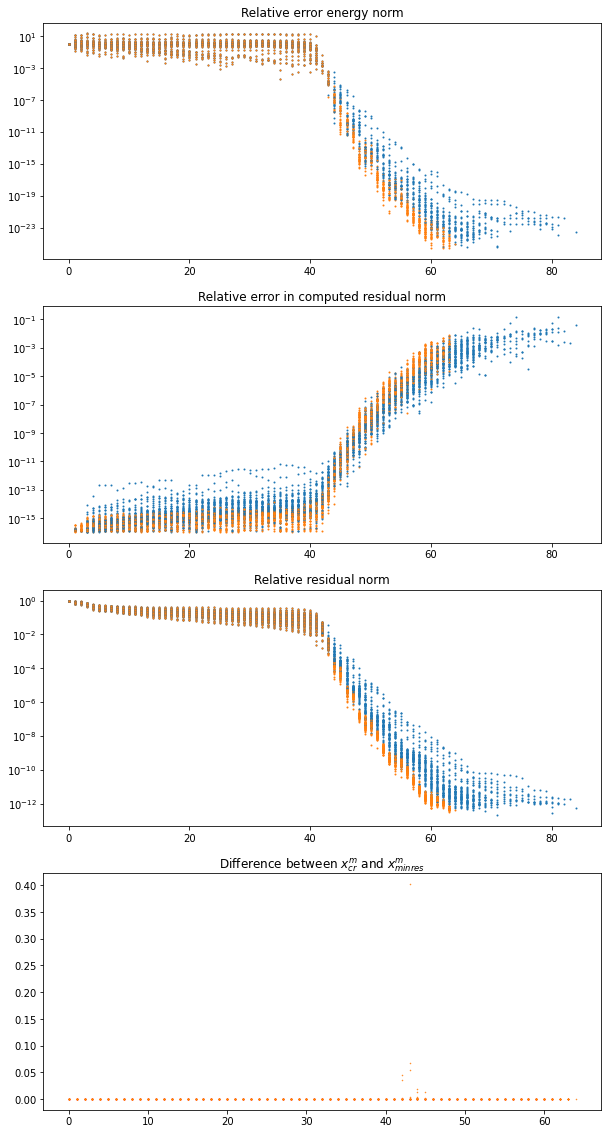

In [14]:
n = 50
m = 500
A = paige_saunders_matrix(n, -3.**0.5)
Q, R, P = qr(A, pivoting=True)
print("condition of A:", np.linalg.cond(A))
print(np.linalg.eigvals(A).min(), np.linalg.eigvals(A).max())
ntrials = 30
fig, axs = plt.subplots(4, 1, figsize=(10, 20))
axs[0].set(title="Relative error energy norm")
axs[1].set(title="Relative error in computed residual norm")
axs[2].set(title="Relative residual norm")
axs[3].set(title="Difference between $x^m_{cr}$ and $x^m_{minres}$")
for trial in range(ntrials*2):
    # Generate a random rhs
    r = np.random.randn(n)
    # Compute the true solution as accurately as possible
    xstar = np.ndarray(r.shape)
    xstar[P] = solve_triangular(R, Q.T @ r)
    xs_cr, rnorms_cr = conjugate_residual(A, r, m)
    xs_mr, rnorms_mr = minres(A, r, m)
    Aerrs_cr = np.array([(xstar - x).dot(A @ (xstar - x)) for x in xs_cr])
    Aerrs_mr = np.array([(xstar - x).dot(A @ (xstar - x)) for x in xs_mr])
    true_rnorms_cr = np.array([np.linalg.norm(A @ x - r) for x in xs_cr])
    true_rnorms_mr = np.array([np.linalg.norm(A @ x - r) for x in xs_mr])
    axs[0].semilogy(range(len(Aerrs_cr)), Aerrs_cr/Aerrs_cr[0], 'C0.',markersize=2)
    axs[0].semilogy(range(len(Aerrs_mr)), Aerrs_mr/Aerrs_mr[0], 'C1.',markersize=2)
    axs[1].semilogy(range(len(true_rnorms_cr)), np.abs(rnorms_cr - true_rnorms_cr) / true_rnorms_cr,'C0.',markersize=2)
    axs[1].semilogy(range(len(true_rnorms_mr)), np.abs(rnorms_mr - true_rnorms_mr) / true_rnorms_mr,'C1.',markersize=2)
    axs[2].semilogy(range(len(true_rnorms_cr)), true_rnorms_cr / np.linalg.norm(r),'C0.',markersize=2)
    axs[2].semilogy(range(len(true_rnorms_mr)), true_rnorms_mr / np.linalg.norm(r),'C1.',markersize=2)
    k = min(len(xs_cr), len(xs_mr))
    diff_mr = [np.linalg.norm(x - xl) / np.linalg.norm(xstar) for x,xl in zip(xs_cr[:k], xs_mr[:k])]
    axs[3].plot(range(k), diff_mr, 'C1.',markersize=1)